In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

np.random.seed(1079)

In [91]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    predictions = predictions.T
    targets = targets.T
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce


class MLP():
    def __init__(self, X, Y, learning_rate=0.05, validation_split=None):
        self.X = X
        self.Y = Y
        self.X_train = self.X_valid = self.Y_train = self.Y_valid = None
        self.lr = learning_rate
        self.validation_split = validation_split
        self.W1 = self.W2 = self.b1 = self.b2 = self.z1 = self.z2 = self.A1 = self.A2 = None
        self.dW1 = self.dW2 = self.db1 = self.db2 = self.dz1 = self.dz2 = None
        self.training_loss = self.validation_loss = None
        self.final_training_loss = self.final_validation_loss = None
    
    def split_samples(self, verbose=False):
        indices = np.arange(N)
        np.random.shuffle(indices)
        x = self.X[:, indices]
        y = self.Y[:, indices]
        vs = 0
        m = self.X.shape[1]
        if self.validation_split is not None:
            vs = int(self.validation_split*m)
        self.X_train = x[:, 0:(m-vs)]
        self.Y_train = y[:, 0:(m-vs)]
        self.X_valid = x[:, (m-vs):]
        self.Y_valid = y[:, (m-vs):]
        if verbose:
            print("-> Total samples = {}\n-> Training samples = {}\n-> Validation samples = {}".format(int(m), int(m)-vs, vs))
        
        
    def initialise_params(self):
        self.W1 = np.random.randn(2, 2)
        self.b1 = np.random.randn(2, 1)
        
        self.W2 = np.random.randn(1, 2)
        self.b2 = np.random.randn(1, 1)

    def sigmoid(self, x):
        return 1/(1 + np.exp(-1*x))
        
    def forward_prop(self, X):
        self.z1 = self.W1@X + self.b1
        self.A1 = self.sigmoid(self.z1)
        
        self.z2 = self.W2@self.A1 + self.b2
        self.A2 = self.sigmoid(self.z2)
    
    def predict_for_valid(self, X):
        z1 = self.W1@X + self.b1
        A1 = self.sigmoid(z1)
        
        z2 = self.W2@A1 + self.b2
        A2 = self.sigmoid(z2)
        return A2
    
    def predict(self, X):
        z1 = self.W1@X + self.b1
        A1 = self.sigmoid(z1)
        
        z2 = self.W2@A1 + self.b2
        A2 = self.sigmoid(z2)
        A2[A2 >= 0.5] = 1
        A2[A2 < 0.5] = 0
        return A2
    
    def train_loss(self, Y):
#         print(Y.shape)
#         return np.mean(np.power(Y - self.A2, 2))
        return cross_entropy(self.A2, Y)
    
    def valid_loss(self, X, Y):
        Y_hat = self.predict_for_valid(X)
#         print(Y_hat.shape)
#         return np.mean(np.power(Y - Y_hat, 2))
        return cross_entropy(Y_hat, Y)
    
    def back_prop(self, X, Y):
        self.dz2 = self.A2*(1 - self.A2) * 2*(self.A2 - Y)
        self.dW2 = self.dz2 @ self.A1.T
        self.db2 = np.sum(self.dz2, axis=1, keepdims=True)
        
        self.dz1 = (self.W2.T @ self.dz2) * (self.A1*(1 - self.A1))
        self.dW1 = self.dz1 @ X.T
        self.db1 = np.sum(self.dz1, axis=1, keepdims=True)
    
    def update_params(self):
        self.W1 -= self.lr * self.dW1
        self.W2 -= self.lr * self.dW2
        self.b1 -= self.lr * self.db1
        self.b2 -= self.lr * self.db2
    
    def train(self, epochs=1, mini_batch_size=1, verbose=True):
        
        self.epoch = epochs 
        
        self.split_samples(verbose)
        
        self.training_loss = np.zeros((1, epochs))
        self.validation_loss = np.zeros((1, epochs))
        
        N_mini_batch_size = int(self.X_train.shape[1] / mini_batch_size)
        
        self.initialise_params()
        
        for i in range(epochs):
            for j in range(N_mini_batch_size-1):
                X = self.X_train[:, (j)*mini_batch_size : (j+1)*mini_batch_size]
                Y = self.Y_train[:, (j)*mini_batch_size : (j+1)*mini_batch_size]
                
                self.forward_prop(X)
                
                self.training_loss[0, i] += (self.train_loss(Y))
                self.validation_loss[0, i] += (self.valid_loss(self.X_valid, self.Y_valid))
                
                self.back_prop(X, Y)
                
                self.update_params()
                
            X = self.X_train[:, (-1*N_mini_batch_size) :]
            Y = self.Y_train[:, (-1*N_mini_batch_size) :]

            self.forward_prop(X)

            self.training_loss[0, i] += (self.train_loss(Y))
            self.validation_loss[0, i] += (self.valid_loss(self.X_valid, self.Y_valid))

            self.back_prop(X, Y)

            self.update_params()  
            if verbose:
                print("Epoch {} :- Training Loss is {}, Validation Loss is {}".format(i+1, self.training_loss[0, i], self.validation_loss[0, i]))
        self.final_training_loss = self.valid_loss(self.X_train, self.Y_train)
        self.final_validation_loss = self.valid_loss(self.X_valid, self.Y_valid)
        
    def plot(self):
        plt.figure()
        plt.xlabel("epoch")
        plt.ylabel("MSE")
        plt.semilogy(np.arange(self.epoch), self.training_loss.reshape(self.epoch, ), label="Training")
        plt.semilogy(np.arange(self.epoch), self.validation_loss.reshape(self.epoch, ), label="Validation")
        plt.legend()
        plt.show()
    
    def print_params(self):
        print("########### Hidden layer #########")
        print("[w11={:.3f} w12={:.3f}]\n[w21={:.3f} w22={:.3f}]".format(self.W1[0, 0], self.W1[0, 1], self.W1[1, 0], self.W1[1, 1]))
        print("[b1={:.3f} b2={:.3f}]".format(self.b1[0, 0], self.b1[1, 0]))
        print("\n")
        print("########## Output layer ##########")
        print("[w1={:.3f} w2={:.3f}]".format(self.W2[0, 0], self.W2[0, 1]))
        print("[b={:.3f}]".format(self.b2[0, 0]))

In [92]:
def generate_samples(N):
    var = 0.001
    X = np.zeros((2, N))
    X[:, 0:4] = np.matrix([[0, 0, 1, 1], [0, 1, 0, 1]])
    Y = np.zeros((1, N))
    
    Y[0, 0:4] = np.array([0, 1, 1, 0])
    
    for i in range(4, N):
        X[0, i] = X[0, i%4] + np.sqrt(var)*np.random.randn()
        X[1, i] = X[1, i%4] + np.sqrt(var)*np.random.randn()
        Y[0, i] = Y[0, i%4]
    
    indices = np.arange(N)
    np.random.shuffle(indices)
    x = X[:, indices]
    y = Y[:, indices]
    return x, y

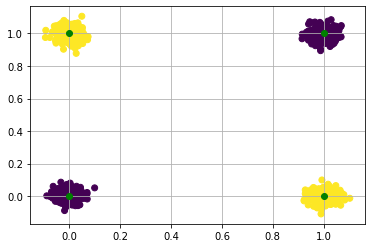

In [93]:
N = 1000
X_xor, Y_xor = generate_samples(N)

plt.figure()
plt.grid()
plt.scatter(X_xor[0, :], X_xor[1, :], c=Y_xor[0])
plt.plot(1, 1, "go")
plt.plot(1, 0, "go")
plt.plot(0, 0, "go")
plt.plot(0, 1, "go")

# Q5 (a)

In [94]:
train_loss = []
val_loss = []

for i in range(0, 120, 20):
    t = time.time()
    XOR = MLP(X_xor, Y_xor, validation_split = 1-(i/100))
    XOR.train(epochs=25, mini_batch_size=64, verbose=False)
    print("[{} ms]".format(np.round((time.time()-t)*1000)), end=" ")
    print("Splits {}:{}".format(i, 100-i), end=" ")
#     train_loss.append(XOR.training_loss[0, -1])
#     val_loss.append(XOR.validation_loss[0, -1])
    train_loss.append(XOR.final_training_loss)
    val_loss.append(XOR.final_validation_loss)
    print("Train Loss: {} Valid Loss: {}".format(np.round(train_loss[-1],2), np.round(val_loss[-1], 2)))

[7.0 ms] Splits 0:100 Train Loss: nan Valid Loss: 0.5
[15.0 ms] Splits 20:80 Train Loss: 0.35 Valid Loss: 0.4
[27.0 ms] Splits 40:60 Train Loss: 0.23 Valid Loss: 0.25
[36.0 ms] Splits 60:40 Train Loss: 0.15 Valid Loss: 0.14
[45.0 ms] Splits 80:20 Train Loss: 0.33 Valid Loss: 0.35
[53.0 ms] Splits 100:0 Train Loss: 0.09 Valid Loss: nan


/tmp/ipykernel_3225/2116762033.py:6: RuntimeWarning: invalid value encountered in double_scalars
  ce = -np.sum(targets*np.log(predictions+1e-9))/N


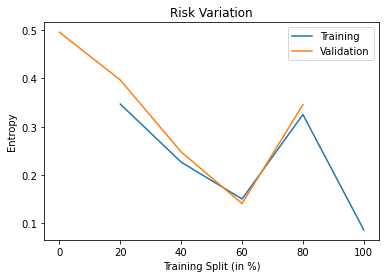

In [95]:
t = np.arange(0, 120, 20)

plt.figure()
plt.title("Risk Variation")
plt.plot(t, train_loss, label='Training')
plt.plot(t, val_loss, label='Validation')
plt.xlabel('Training Split (in %)')
plt.ylabel('Entropy')
plt.legend()
plt.show()

# Q5 (b)

In [96]:
%%time

train_loss = 0
val_loss = 0

vs = np.arange(1, 10)/10
Ns = [1000, 5000, 10000]
nMC = 10 #Monte Carlo Simulation

for _ in range(nMC):
    Train_loss = []
    Val_loss = []

    for vss in vs:
        Train_loss.append([])
        Val_loss.append([])
        for N in Ns:
            t = time.time()
            X_xor, Y_xor = generate_samples(N)
            XOR = MLP(X_xor, Y_xor, validation_split = vss)
            XOR.train(epochs=25, mini_batch_size=256, verbose=False)
    #         print("[{} ms]".format(np.round((time.time()-t)*1000)), end=" ")
    #         print("N {}".format(N), end=" ")
    #         print("Valid Split {}".format(vss), end=" ")
            Train_loss[-1].append(XOR.training_loss[0, -1])
            Val_loss[-1].append(XOR.validation_loss[0, -1])
    #         print("Train Loss: {} Valid Loss: {}".format(np.round(train_loss[-1][-1],2), np.round(val_loss[-1][-1], 2)))

    train_loss  += np.array(Train_loss)
    val_loss += np.array(Val_loss)

train_loss /= nMC
val_loss /= nMC

CPU times: user 2min 57s, sys: 1min 58s, total: 4min 55s
Wall time: 59 s


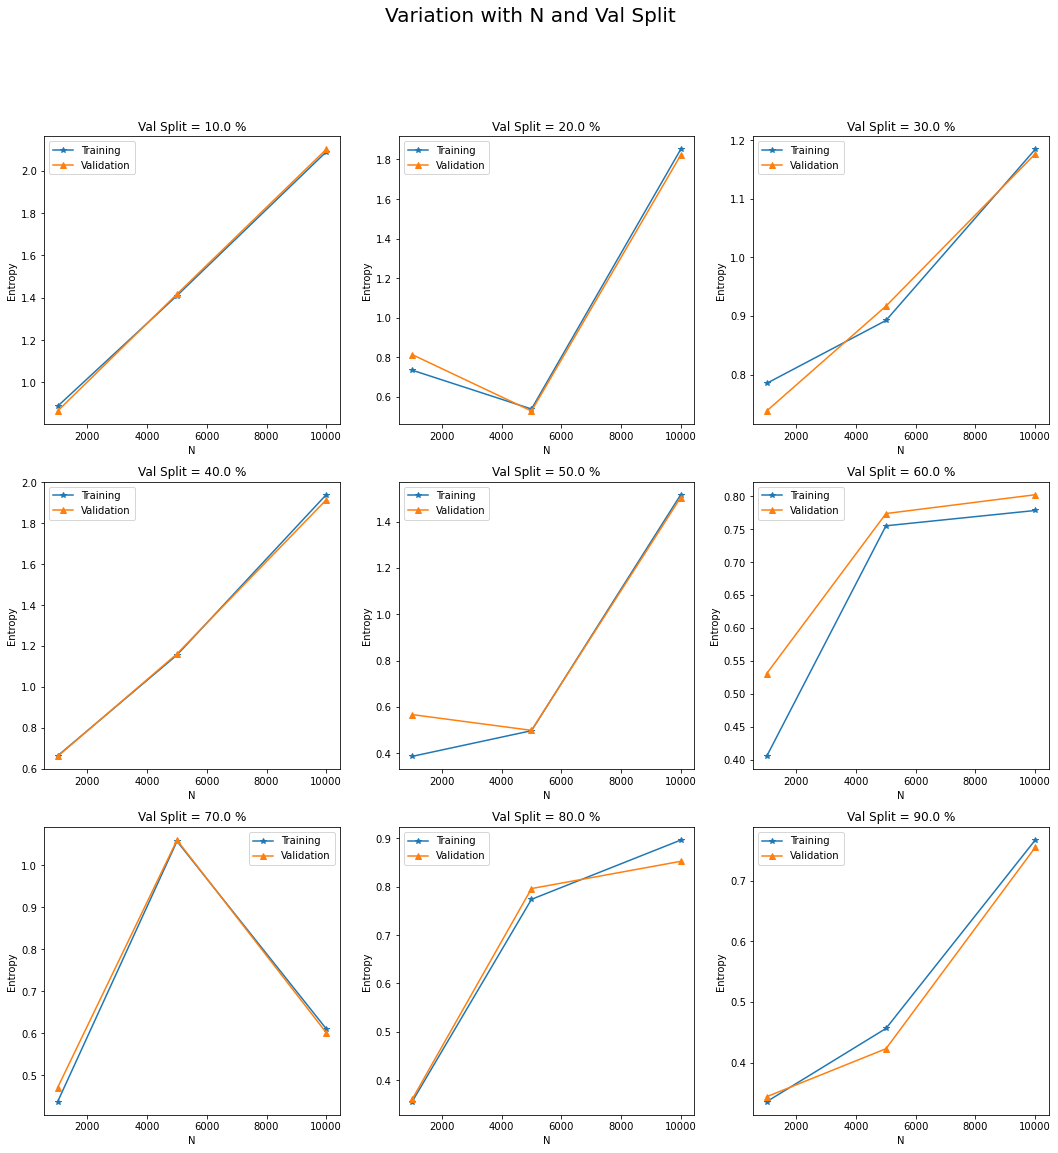

In [97]:
plt.figure(figsize=(18, 18))
plt.suptitle("Variation with N and Val Split", fontsize=20)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.title("Val Split = {} %".format(np.round(100*vs[i])))
    plt.plot(Ns, train_loss[i], '-*', label='Training')
    plt.plot(Ns, val_loss[i], '^-', label='Validation')
    plt.xlabel('N')
    plt.ylabel('Entropy')
    plt.legend()
#     plt.ylim([0, 2])
#     plt.show()

# Observations
1. 
2. 
3. 